In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np

import os

# from model import Net

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
fast = True
fast = False

In [66]:
# Define Noise function
def add_noise(x, device='cpu'):
    normal = torch.distributions.Normal(0, 0.5)
    return x + normal.sample(sample_shape=torch.Size(x.shape)).to(device)

In [67]:
class NoisyDataset(Dataset):
  
  def __init__(self,datasetnoised,datasetclean,labels,transform):
    self.noise=datasetnoised
    self.clean=datasetclean
    self.labels=labels
    self.transform=transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self,idx):
    xNoise=self.noise[idx]
    xClean=self.clean[idx]
    y=self.labels[idx]
    
    if self.transform != None:
      xNoise=self.transform(xNoise)
      xClean=self.transform(xClean)
      
    
    return (xNoise,xClean,y)
      

In [68]:
# Loading the dataset
classes = list(str(i) for i in range(10))

transform = transforms.Compose(
    [
        # transforms.RandomAffine(degrees=60, translate=(0.2, 0.2), scale=(0.5, 2.), 
                                            #    shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))])

batch_size = 20

trainset = torchvision.datasets.MNIST(root='./data_mnist', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data_mnist', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [78]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        
        self.fc4 = nn.Linear(64, 128)
        self.fc5 = nn.Linear(128, 256)
        self.fc6 = nn.Linear(256, 28*28)
        
    def encoder(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x
        
    def decoder(self, x):
        x = F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.fc5(x))
        x = F.leaky_relu(self.fc6(x))
        # x = torch.reshape(28, 28, -1)
        return x

    def forward(self,x):
        # shape = x.shape
        shape = (-1, 1, 28, 28)
        x = torch.flatten(x, 1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = torch.reshape(x, shape)
        return x

You can visualize some of the pre-processed images here (This is optional and only for your own reference).


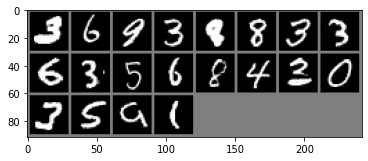

In [79]:
# Visualize samples
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
if not fast:
    # Show samples
    message = 'You can visualize some of the pre-processed images here (This is optional and only for your own reference).'
    print(message)

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    # print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [80]:
# Load Model
net = Net().to(device)
summary(net, (1, 28, 28))
print(torch.randn(1,28,28).shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
            Linear-2                  [-1, 128]          32,896
            Linear-3                   [-1, 64]           8,256
            Linear-4                  [-1, 128]           8,320
            Linear-5                  [-1, 256]          33,024
            Linear-6                  [-1, 784]         201,488
Total params: 484,944
Trainable params: 484,944
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.85
Estimated Total Size (MB): 1.87
----------------------------------------------------------------
torch.Size([1, 28, 28])


In [81]:
# Set training parameters
epochs = 50
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(),lr=0.01,weight_decay=1e-5) 
optimizer = optim.Adam(net.parameters(), lr=0.001)

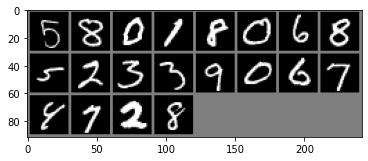

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


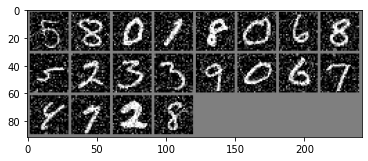

In [82]:
counter = 0
for i, data in enumerate(trainloader, 0):
    if counter == 0:
        imshow(torchvision.utils.make_grid(data[0]))
        imshow(torchvision.utils.make_grid(add_noise(data[0])))
        counter += 1
        break

In [83]:
# Train
losslist = []
num_data = len(trainloader)
for epoch in range(epochs):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        imgs, _ = data
        # img = img.view(img.size(0), -1).type(torch.FloatTensor)
        noisy_img = add_noise(imgs)
        
        imgs = imgs.to(device)
        noisy_img = noisy_img.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(noisy_img)
        # print(inputs.shape) # [batch_size, 1, 28, 28]
        # print(outputs.shape)
        # print(labels.shape)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 500))
            # running_loss = 0.0
    
    losslist.append(running_loss)
        
print('Finished Training')

[1,   500] loss: 0.304
[1,  1000] loss: 0.573
[1,  1500] loss: 0.841
[1,  2000] loss: 1.106
[1,  2500] loss: 1.356
[1,  3000] loss: 1.594
[2,   500] loss: 0.230
[2,  1000] loss: 0.448
[2,  1500] loss: 0.657
[2,  2000] loss: 0.862
[2,  2500] loss: 1.061
[2,  3000] loss: 1.256
[3,   500] loss: 0.192
[3,  1000] loss: 0.381
[3,  1500] loss: 0.569
[3,  2000] loss: 0.755
[3,  2500] loss: 0.940
[3,  3000] loss: 1.121
[4,   500] loss: 0.179
[4,  1000] loss: 0.358
[4,  1500] loss: 0.534
[4,  2000] loss: 0.709
[4,  2500] loss: 0.881
[4,  3000] loss: 1.051
[5,   500] loss: 0.166
[5,  1000] loss: 0.331
[5,  1500] loss: 0.495
[5,  2000] loss: 0.657
[5,  2500] loss: 0.815
[5,  3000] loss: 0.973
[6,   500] loss: 0.216
[6,  1000] loss: 0.371
[6,  1500] loss: 0.524
[6,  2000] loss: 0.675
[6,  2500] loss: 0.824
[6,  3000] loss: 0.971
[7,   500] loss: 0.145
[7,  1000] loss: 0.290
[7,  1500] loss: 0.433
[7,  2000] loss: 0.575
[7,  2500] loss: 0.716
[7,  3000] loss: 0.856
[8,   500] loss: 0.138
[8,  1000] 

In [84]:
PATH = './mnist_dae_net_sigmoid.pth'
torch.save(net.state_dict(), PATH)

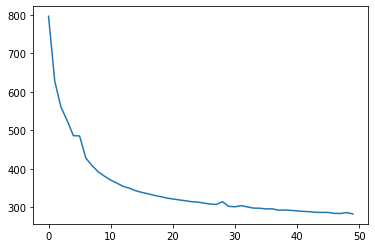

In [85]:
plt.plot(losslist)

In [86]:
testset[0][1]

7

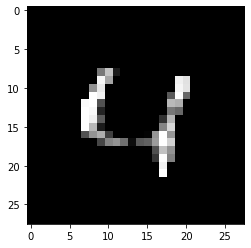

In [92]:
with torch.no_grad():
    img = testset[4][0]
    noisy_img = add_noise(img)
    # plt.imshow(img[0])
    # plt.imshow(noisy_img[0])
    output = net(noisy_img.to(device)).to("cpu")
    plt.imshow(output[0][0], 'gray', vmin=0, vmax=1)
    # print(min(output[0][0]))
    